# Virgo Demo 1 - Base pipeline

In [1]:
from virgo.cluster import VirgoCluster
from virgo.kernel import VirgoSimpleKernel
from virgo.mixture import VirgoMixture
from virgo.cleaner import LowDensityCleaner

%load_ext autoreload
%autoreload 2

%matplotlib notebook

### Data class

VirgoCluster is meant to be the base class for data handling. It stores separately raw data, the rescaled data set and the final cluster and cluster_label arrays.The rescaled data set is created of the scale_data() class method is called. print_datastats() prints a few helper info about the stored datasets.

Virgo can process txt files as well as simulation snaps. The io_mode has to be sed accordingly (default io_mode=0 for txt files.) Optionally, the mach number dimension can be filtered. By default, this is not done, but the default ceiling and floor values are 15 and 1.

Reading  1157804  particles
Data set 0 - Shape: (603174, 8)
Mean / Std: 71385.634 / 222255.524
Min / Max: -7999.824 / 1157658.000
Data set 1 - Shape: (603174, 7)
Mean / Std: -0.000 / 1.000
Min / Max: -4.731 / 7.263


<IPython.core.display.Javascript object>


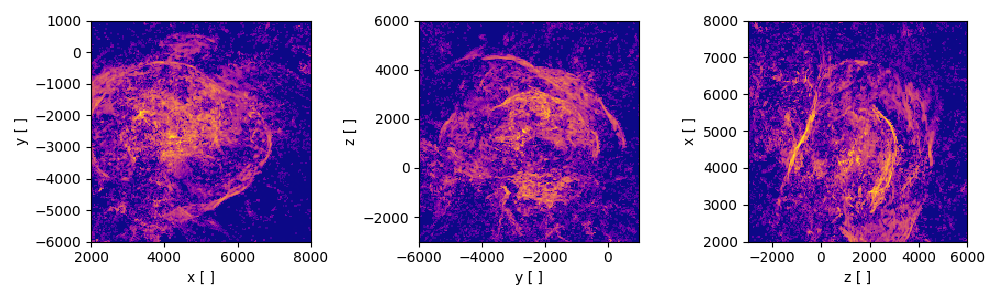

In [5]:
filebase = "/home/max/Software/virgo/data/VIRGO/snap_850"
virgo_cluster = VirgoCluster(file_name=filebase, io_mode=1, cut_mach_dim=-2)
virgo_cluster.data = virgo_cluster.data[:, :-1]

upper = [9000., 3000., 8000.]
lower = [-3000., -8000., -3000.]
for i in range(1, 4):
    mask = virgo_cluster.data[:, i] <= upper[i-1]
    virgo_cluster.data = virgo_cluster.data[mask]
    mask = virgo_cluster.data[:, i] >= lower[i-1]
    virgo_cluster.data = virgo_cluster.data[mask]
    

virgo_cluster.scale_data()
virgo_cluster.print_datastats()
virgo_cluster.plot_raw_hists(bins=200, plot_range=[[2000., 8000.], [-6000., 1000.], [-3000., 6000.]])

### Kernel

Virgo uses a covariance function to create additional feature space dimensions by leveraging correlations in the datasets itself. For the time being this is a very simple LinearKernel. VirgoKernel needs to be instantiated with the corresponding VirgoCluster object and then just called. For VirgoSimple kernel, the new feature dimensions are added to the rescaled data set automatically, as can be seen from the stats output.

Currently, only the spatial dimensions are used for the kernel. Dimensions to use can be passed as list.

In [6]:
virgo_kernel = VirgoSimpleKernel(virgo_cluster)
virgo_kernel()
virgo_cluster.print_datastats()

Data set 0 - Shape: (603174, 8)
Mean / Std: 71385.634 / 222255.524
Min / Max: -7999.824 / 1157658.000
Data set 1 - Shape: (603174, 8)
Mean / Std: 2.599 / 11.090
Min / Max: -4.731 / 262.711


### Gaussian mixture fit model

We are using a Gaussian mixture model to classify the data. The VirgoMixture class currently has a GaussianMixture model with fixed number of components and a BayesianGaussianMixture model with a Dirichlet process prior to downweight unneeded components. We currently employ the former as default for the time being.

The evidence lower bound is returned as goodness-of-fit measure and the component weights can be called from the model as attribute.

Calling the predict() method without any data as input, automatically sets the labels for the entire dataset in the VirgoCluster. The option to remove labels with a probability below 95% is also there, but not called on default. The threshhold can be changed as an input parameter as well.

In [7]:
virgo_mixture = VirgoMixture(virgo_cluster, n_comp=12)
# virgo_mixture = VirgoMixture(virgo_cluster, n_comp=25, mixture_type="bayesian_gaussian")
elbo = virgo_mixture.fit()

print(f"ELBO: {elbo}")
print(f"Mixture weights {virgo_mixture.model.weights_}")

virgo_mixture.predict(remove_uncertain_labels=True)
labels_removed = virgo_cluster.get_labels(return_counts=True)
print(labels_removed)

ELBO: -8.464020049161965
Mixture weights [0.05435929 0.16847656 0.03227947 0.04930698 0.11517861 0.03835382
 0.06590867 0.10721377 0.07433279 0.07229168 0.10006912 0.12222923]
Removed 113799
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([113799,  96593,  61804,  57512,  55701,  48637,  42449,  31506,
        28707,  21911,  18299,  13945,  12311]))


### Visualization 

VirgoCluster has a general plotting method plot_cluster() to visualize the fitted data. Specific labels can be called via list input. "Removed" uncertain labels are automatically not shown, but can be switched on again. Maker size is also an input parameter. The 3D-plots can be exported as gif as well.

<IPython.core.display.Javascript object>


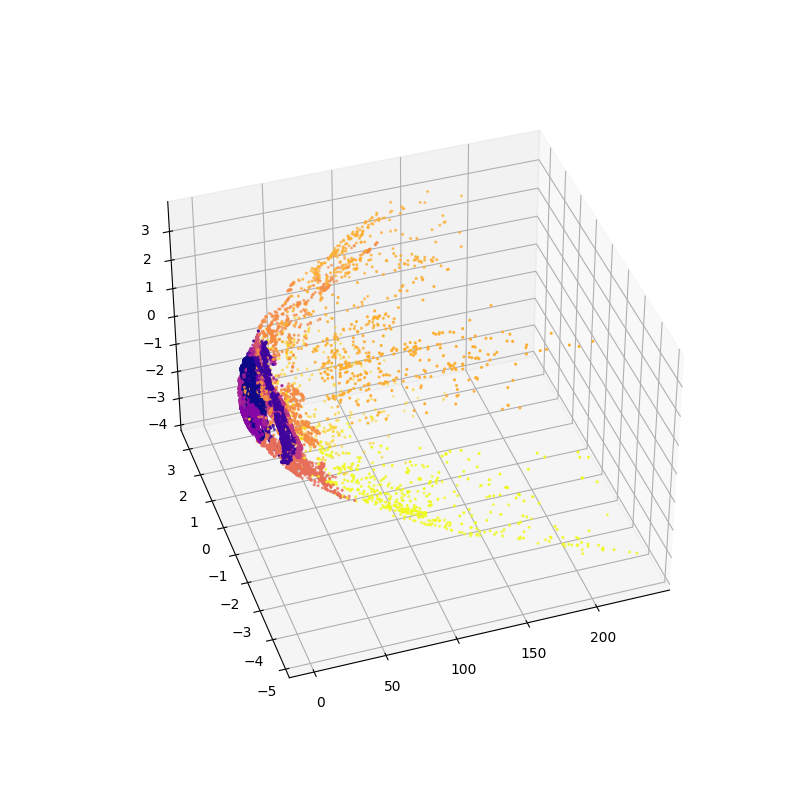

<IPython.core.display.Javascript object>


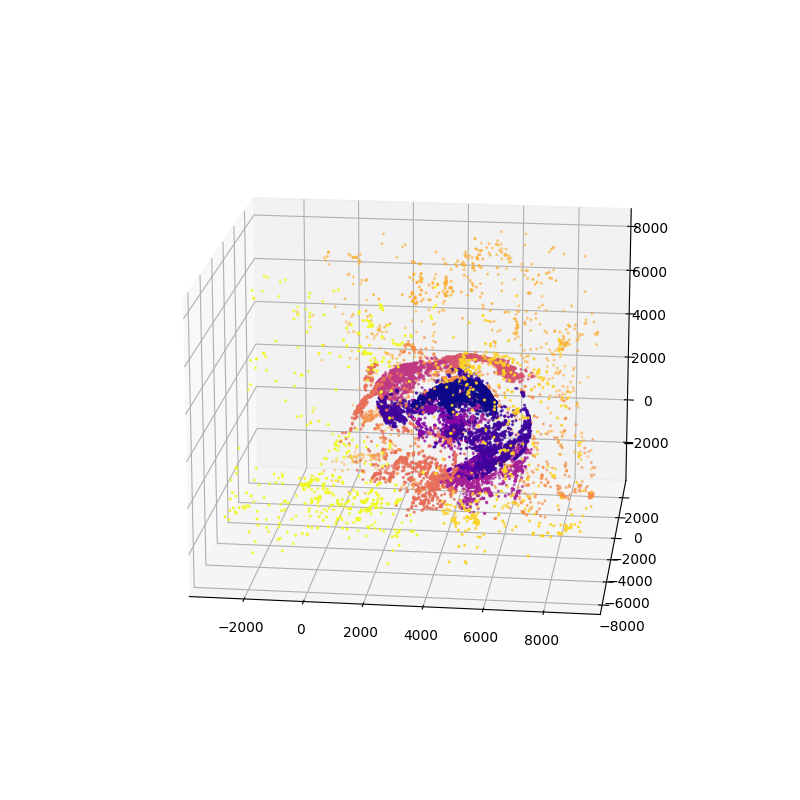

In [8]:
virgo_cluster.plot_cluster(n_step=25, plot_kernel_space=True, store_gif=False)
virgo_cluster.plot_cluster(n_step=25, store_gif=False)

<IPython.core.display.Javascript object>


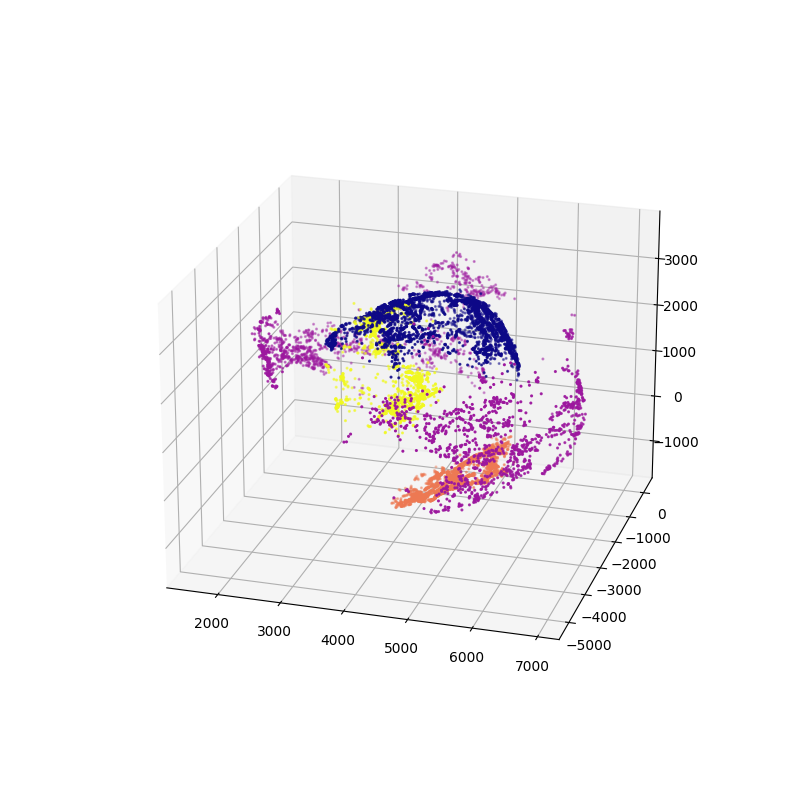

In [9]:
virgo_cluster.plot_cluster(n_step=25, cluster_label=[0, 1, 2, 3])

<IPython.core.display.Javascript object>


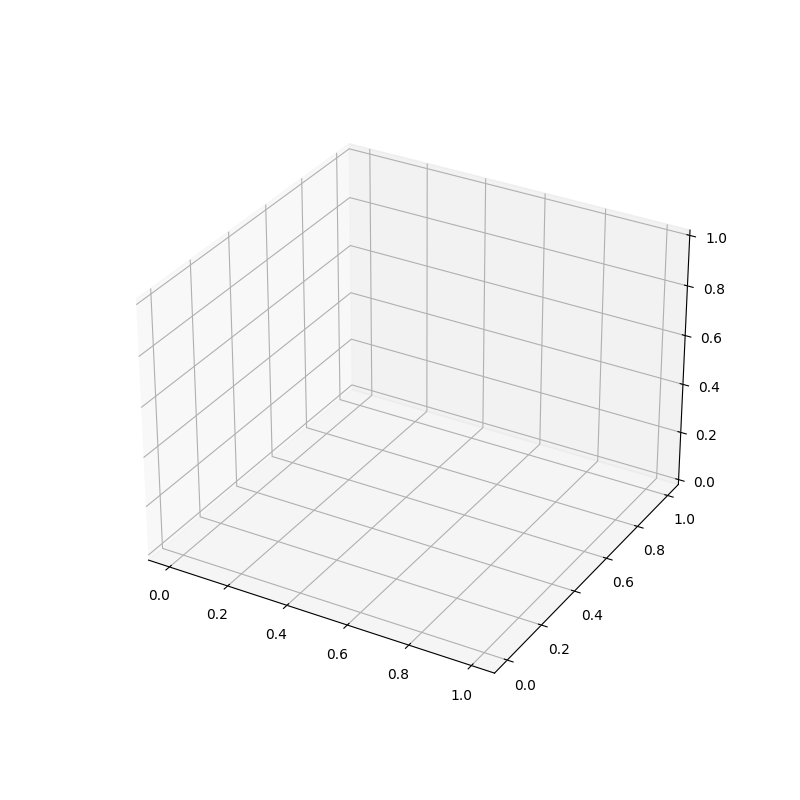

In [10]:
virgo_cluster.plot_cluster(n_step=10, remove_uncertain=False, cluster_label=[-1])

### Cleaning

We can further clean the resulting clusters by either further separating a cluster by checking with a two component GaussianMixture fit or by removing low density clusters who are of low interest to our problem. The latter is more stable for the time being, as both rely on an emiprical parameter, but the density cut is physically motivated and easier to verify.

Relabeling due to cluster size ist called on default, but can be set to False.

<IPython.core.display.Javascript object>


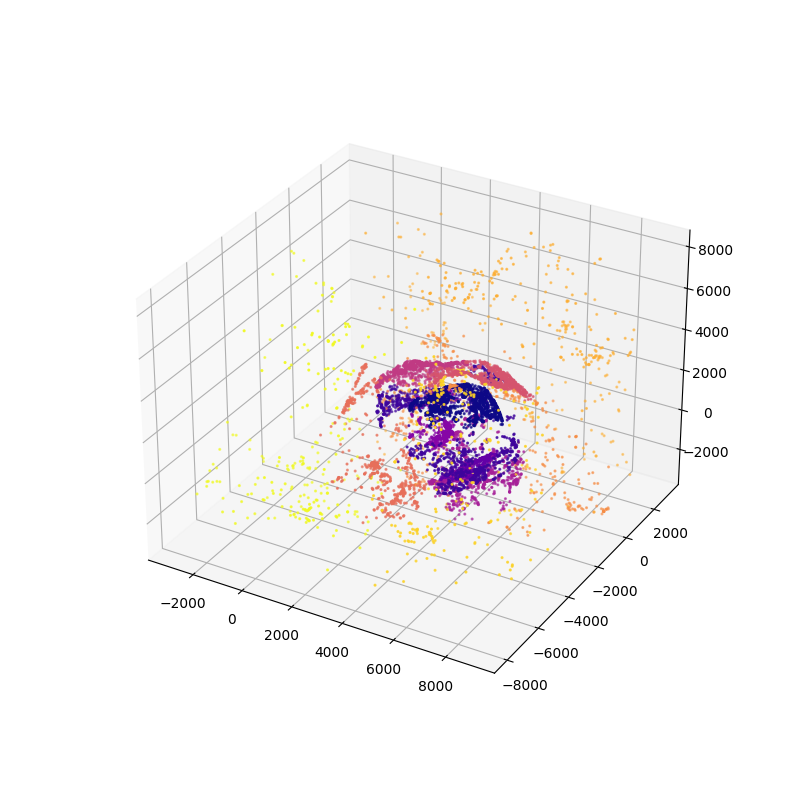

(array([-20,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
         11]),
 array([ 11285, 102514,  96593,  61804,  57512,  55701,  48637,  42449,
         31506,  28707,  21911,  18299,  13945,  12311]))

In [11]:
virgo_cluster.plot_cluster(n_step=50)
virgo_cluster.get_labels(return_counts=True)

Cluster -1
Cluster 0
Density: 5.244484489904969e-07
Cluster 1
Density: 2.336940405675263e-08
Cluster 2
Density: 1.7391448765325188e-06
Cluster 3
Density: 3.7412711558433314e-07
Cluster 4
Density: 3.086885661088574e-08
Cluster 5
Density: 1.1275035018163164e-07
Cluster 6
Density: 2.2425905647370428e-07
Cluster 7
Density: 8.42958253897665e-09
Cluster 8
Density: 2.7160061297927407e-09
Cluster 9
Density: 2.0867246611416957e-10
Cluster 10
Density: 2.7401129762897856e-10
Cluster 11
Density: 1.7545142793514402e-10
(array([-1,  0,  1,  2,  3,  4,  5,  6]), array([208972,  96593,  61804,  57512,  55701,  48637,  42449,  31506]))


<IPython.core.display.Javascript object>


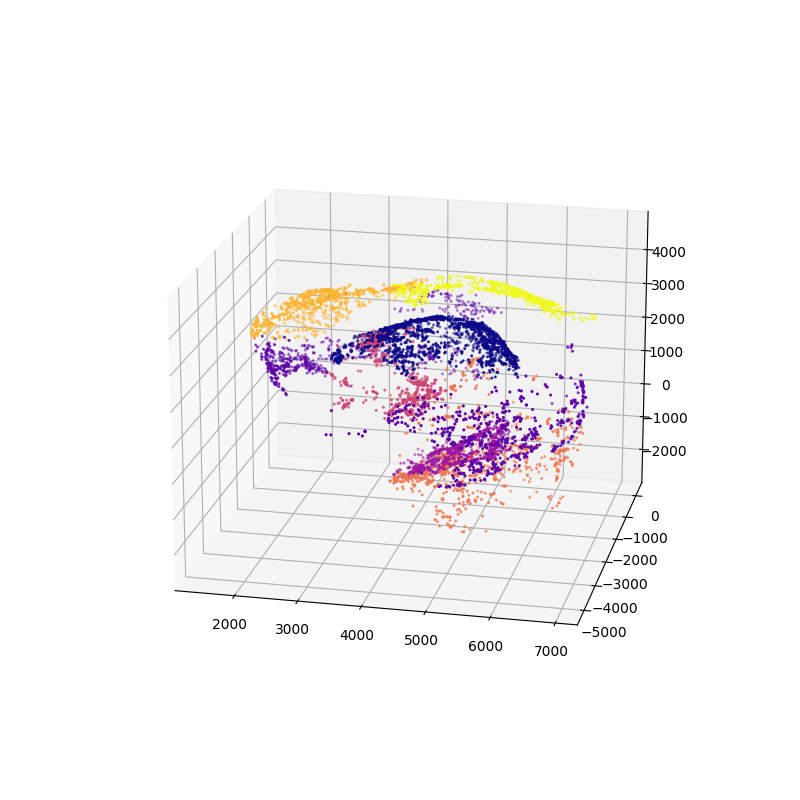

In [13]:
d_cleaner = LowDensityCleaner(virgo_cluster, 1e-8)
d_cleaner.clean()
print(virgo_cluster.get_labels(return_counts=True))
virgo_cluster.plot_cluster(n_step=50)

<IPython.core.display.Javascript object>


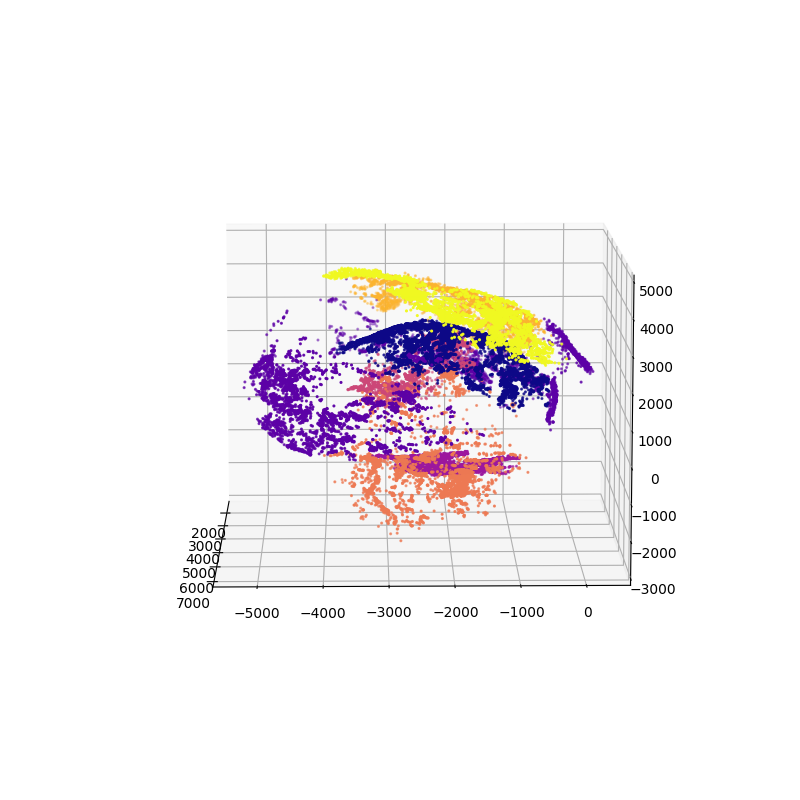

MovieWriter imagemagick unavailable; using Pillow instead.


In [17]:
virgo_cluster.plot_cluster(
    n_step=10, cluster_label=[0, 1, 2, 3, 4, 5, 6], store_gif=True, gif_title="850_gmm_simple_cleaned"
)

### Export results

Cluster results, in the original data format, and their labels can be exported with VirgoCluster.export_cluster(). Event numbers (added 0th dimension) can be removed again and only positiv labels can be filtered (both False on default):

In [11]:
# virgo_cluster.export_cluster(remove_uncertain=True, remove_evno=True)